In [21]:
import os, sys, math, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import Optional, Literal, Dict, Any, Iterable
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", context="notebook")

# -------- PATHS --------
INPUT_CSV = "training_data.csv"  # <-- change this if your file has a different name
# -------- SCORER DEFAULTS --------
USE_SEX    = False     # keep False for compliance unless you are only experimenting
BAD_THRESH = 3.0       # ↑ threshold => fewer 'bad' predictions; ↓ => more 'bad' predictions

# Create an outputs folder to keep images & csvs tidy
os.makedirs("outputs", exist_ok=True)
print("Working directory:", os.getcwd())

Working directory: /Users/joetate/Desktop/University/Year 2/Semester 1/Artificial-Intelligence/Assessment


In [22]:
# If you're in a fresh environment, you may need:
# !pip install pandas numpy matplotlib seaborn scikit-learn

import os, sys, math, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import Optional, Literal, Dict, Any, Iterable
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", context="notebook")

# -------- PATHS --------
INPUT_CSV = "training_data.csv"  # <-- change this if your file has a different name
# -------- SCORER DEFAULTS --------
USE_SEX    = False     # keep False for compliance unless you are only experimenting
BAD_THRESH = 3.0       # ↑ threshold => fewer 'bad' predictions; ↓ => more 'bad' predictions

# Create an outputs folder to keep images & csvs tidy
os.makedirs("outputs", exist_ok=True)
print("Working directory:", os.getcwd())

Working directory: /Users/joetate/Desktop/University/Year 2/Semester 1/Artificial-Intelligence/Assessment


In [23]:
SexT = Literal["male", "female"]
HousingT = Literal["own", "rent", "free"]
SavingsT = Literal["little", "moderate", "quite rich", "rich"]
PurposeT = Literal[
    "car", "furniture/equipment", "radio/TV",
    "domestic appliances", "repairs", "education",
    "business", "vacation/others"
]

ALL_FEATURES = {
    "Age","Sex","Job","Housing","Saving accounts",
    "Checking account","Credit amount","Duration","Purpose"
}

@dataclass
class RuleConfig:
    use_sex: bool = USE_SEX
    bad_threshold: float = BAD_THRESH
    explain: bool = False
    # Limit which features the rules are allowed to use (for subset experiments)
    available_features: Iterable[str] = tuple(sorted(ALL_FEATURES))

class RuleBasedCreditScorer:
    """Deterministic, explainable rule-based credit scorer compatible with your schema."""
    def __init__(self, config: Optional[RuleConfig] = None):
        self.cfg = config or RuleConfig()
        self.available = set(self.cfg.available_features)

    def predict(
        self,
        Age: Optional[int] = None,
        Sex: Optional[str] = None,
        Job: Optional[int] = None,
        Housing: Optional[str] = None,
        Saving_accounts: Optional[str] = None,
        Checking_account: Optional[object] = None,
        Credit_amount: Optional[float] = None,
        Duration: Optional[int] = None,
        Purpose: Optional[str] = None,
    ) -> Dict[str, Any]:

        score = 0.0
        details = []

        # ---- Age ----
        if "Age" in self.available and pd.notna(Age):
            if Age < 25: score += 2; details.append(("Age", +2, "Age < 25"))
            elif Age > 60: score += 1; details.append(("Age", +1, "Age > 60"))
            else: details.append(("Age", 0, "25–60"))

        # ---- Sex (ignored unless enabled; stays neutral here) ----
        if "Sex" in self.available and self.cfg.use_sex and isinstance(Sex, str):
            details.append(("Sex", 0, "Neutral"))  # do not influence the score

        # ---- Job ----
        if "Job" in self.available and pd.notna(Job):
            job_pts = {0: 2, 1: 1, 2: 0, 3: -1}.get(int(Job), 0)
            score += job_pts; details.append(("Job", job_pts, f"Job={Job}"))

        # ---- Housing ----
        if "Housing" in self.available and isinstance(Housing, str):
            housing_pts = {"own": -1, "rent": +1, "free": 0}.get(Housing.strip().lower(), 0)
            score += housing_pts; details.append(("Housing", housing_pts, f"Housing={Housing}"))

        # ---- Saving accounts ----
        if "Saving accounts" in self.available:
            if Saving_accounts is None or (isinstance(Saving_accounts, float) and np.isnan(Saving_accounts)):
                score += 1; details.append(("Saving accounts", +1, "Missing"))
            else:
                sav_pts = {"little": +2, "moderate": +1, "quite rich": -1, "rich": -2}.get(
                    str(Saving_accounts).strip().lower(), +1
                )
                score += sav_pts; details.append(("Saving accounts", sav_pts, f"{Saving_accounts}"))

        # ---- Checking account (numeric DM or categorical strings) ----
        if "Checking account" in self.available:
            chk_pts = score_checking(Checking_account)
            score += chk_pts; details.append(("Checking account", chk_pts, f"{Checking_account}"))

        # ---- Credit_amount / Duration / Monthly burden ----
        if {"Credit amount","Duration"} <= self.available and pd.notna(Credit_amount) and pd.notna(Duration):
            duration = max(int(Duration), 1)
            monthly_burden = float(Credit_amount) / duration
            if monthly_burden > 400: score += 2; details.append(("Monthly burden", +2, f"{monthly_burden:.1f} > 400"))
            elif monthly_burden > 200: score += 1; details.append(("Monthly burden", +1, f"200–400 ({monthly_burden:.1f})"))
            elif monthly_burden < 100: score += -1; details.append(("Monthly burden", -1, f"< 100 ({monthly_burden:.1f})"))
            else: details.append(("Monthly burden", 0, f"100–200 ({monthly_burden:.1f})"))

            if Credit_amount > 10_000: score += 1; details.append(("Credit amount", +1, "> 10,000 DM"))
            elif Credit_amount > 5_000: score += 0.5; details.append(("Credit amount", +0.5, "5,000–10,000 DM"))
            else: details.append(("Credit amount", 0, "≤ 5,000 DM"))

            if duration > 36: score += 1; details.append(("Duration", +1, "> 36 mo"))
            elif duration < 12: score += -1; details.append(("Duration", -1, "< 12 mo"))
            else: details.append(("Duration", 0, "12–36 mo"))

        # ---- Purpose ----
        if "Purpose" in self.available and isinstance(Purpose, str):
            purpose_pts = {
                "business": +1, "education": +1, "repairs": +1, "domestic appliances": +1,
                "car": 0, "furniture/equipment": 0, "radio/tv": 0, "vacation/others": 0
            }.get(Purpose.strip().lower(), 0)
            score += purpose_pts; details.append(("Purpose", purpose_pts, f"{Purpose}"))

        label = "bad" if score >= self.cfg.bad_threshold else "good"
        out = {"prediction": label, "score": round(score, 2)}
        if self.cfg.explain:
            out["explanation"] = details
        return out

def score_checking(val: Optional[object]) -> float:
    """Score Checking account whether it's numeric DM or a categorical string."""
    if val is None or (isinstance(val, float) and np.isnan(val)): return +1
    if isinstance(val, (int, float)):
        v = float(val)
        if v < 200:  return +2
        if v < 500:  return +1
        return -1    # 500 DM or more
    v = str(val).strip().lower()
    if v == "little":    return +2
    if v == "moderate":  return +1
    if v == "rich":      return -1
    return +1  # unknown category

In [24]:
def predict_df(df_in: pd.DataFrame, available_features, bad_threshold=BAD_THRESH, use_sex=USE_SEX):
    scorer = RuleBasedCreditScorer(RuleConfig(
        use_sex=use_sex, bad_threshold=bad_threshold, available_features=available_features
    ))
    preds, scores = [], []
    for _, r in df_in.iterrows():
        res = scorer.predict(
            Age=r.get("Age"), Sex=r.get("Sex"), Job=r.get("Job"), Housing=r.get("Housing"),
            Saving_accounts=r.get("Saving accounts"), Checking_account=r.get("Checking account"),
            Credit_amount=r.get("Credit amount"), Duration=r.get("Duration"), Purpose=r.get("Purpose")
        )
        preds.append(res["prediction"]); scores.append(res["score"])
    out = df_in.copy()
    out["y_pred"] = preds
    out["score"]  = scores
    return out

def evaluate(y_true, y_pred):
    labels = ["good", "bad"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    acc = accuracy_score(y_true, y_pred)
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    metrics = {
        "accuracy": acc,
        "cm": cm,
        "precision_good": rep["good"]["precision"],
        "recall_good": rep["good"]["recall"],
        "precision_bad": rep["bad"]["precision"],
        "recall_bad": rep["bad"]["recall"],
        "support": len(y_true)
    }
    return metrics

def plot_confusion_matrix(cm, title, save_path=None):
    labels = ["good", "bad"]
    plt.figure(figsize=(5.5,4.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

In [25]:
# Define subsets
PERSONAL = {"Age","Sex","Job","Housing","Saving accounts","Checking account"}
LOAN     = {"Credit amount","Duration","Purpose"}
FULL     = ALL_FEATURES

# Evaluate full
pred_full = predict_df(df, FULL)
m_full = evaluate(df["Risk"], pred_full["y_pred"])

# Evaluate personal-only
pred_personal = predict_df(df, PERSONAL)
m_personal = evaluate(df["Risk"], pred_personal["y_pred"])

# Evaluate loan-only
pred_loan = predict_df(df, LOAN)
m_loan = evaluate(df["Risk"], pred_loan["y_pred"])

# Summary table
summary = pd.DataFrame([
    {"subset": "Full (all features)", "accuracy": m_full["accuracy"],
     "prec_good": m_full["precision_good"], "rec_good": m_full["recall_good"],
     "prec_bad": m_full["precision_bad"], "rec_bad": m_full["recall_bad"]},
    {"subset": "Personal only", "accuracy": m_personal["accuracy"],
     "prec_good": m_personal["precision_good"], "rec_good": m_personal["recall_good"],
     "prec_bad": m_personal["precision_bad"], "rec_bad": m_personal["recall_bad"]},
    {"subset": "Loan only", "accuracy": m_loan["accuracy"],
     "prec_good": m_loan["precision_good"], "rec_good": m_loan["recall_good"],
     "prec_bad": m_loan["precision_bad"], "rec_bad": m_loan["recall_bad"]}
]).round(3)

display(summary)

,subset,accuracy,prec_good,rec_good,prec_bad,rec_bad
0,Full (all features),0.612,0.617,0.588,0.606,0.636
1,Personal only,0.617,0.618,0.611,0.616,0.623
2,Loan only,0.523,0.512,0.988,0.825,0.059


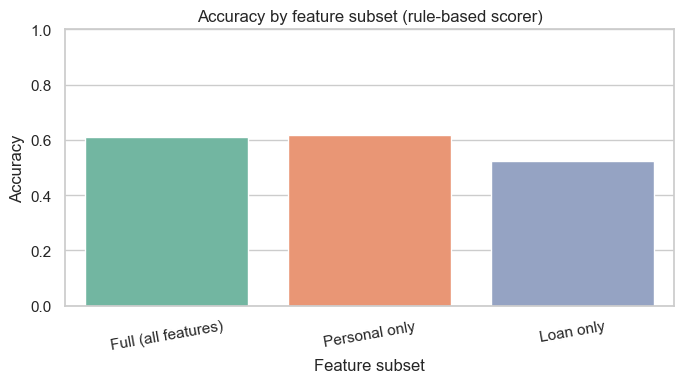

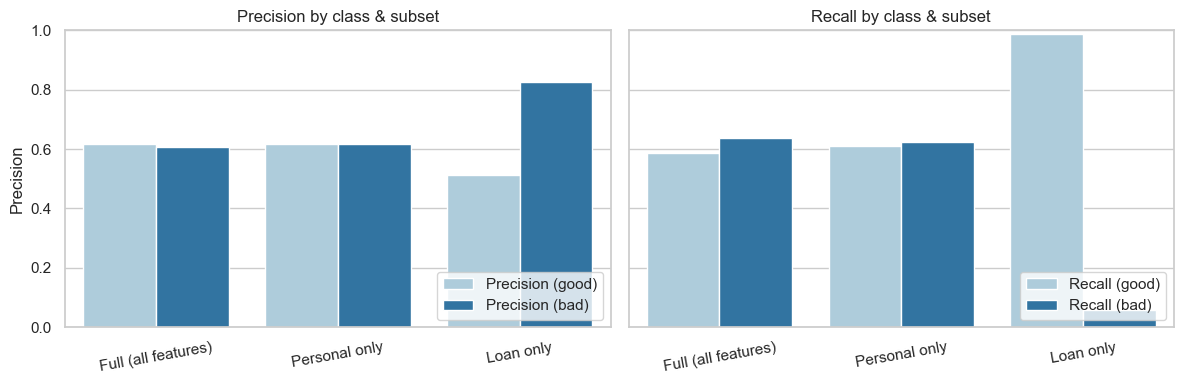

In [26]:
# 1) Accuracy comparison
plt.figure(figsize=(7,4))
sns.barplot(data=summary, x="subset", y="accuracy", palette="Set2")
plt.ylim(0,1)
plt.title("Accuracy by feature subset (rule-based scorer)")
plt.xlabel("Feature subset"); plt.ylabel("Accuracy")
plt.xticks(rotation=10)
plt.tight_layout()
plt.savefig("outputs/viz_accuracy_by_subset.png", dpi=200)
plt.show()

# 2) Precision / Recall grouped bars
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

# Precision
prec_df = pd.melt(
    summary[["subset","prec_good","rec_good","prec_bad","rec_bad"]]
        .rename(columns={"prec_good":"Precision (good)",
                         "prec_bad":"Precision (bad)"}),
    id_vars="subset", value_vars=["Precision (good)","Precision (bad)"],
    var_name="metric", value_name="value"
)
sns.barplot(data=prec_df, x="subset", y="value", hue="metric", palette="Paired", ax=axes[0])
axes[0].set_title("Precision by class & subset"); axes[0].set_ylim(0,1)
axes[0].set_xlabel(""); axes[0].set_ylabel("Precision"); axes[0].tick_params(axis="x", rotation=10)
axes[0].legend(loc="lower right")

# Recall
rec_df = pd.melt(
    summary[["subset","prec_good","rec_good","prec_bad","rec_bad"]]
        .rename(columns={"rec_good":"Recall (good)",
                         "rec_bad":"Recall (bad)"}),
    id_vars="subset", value_vars=["Recall (good)","Recall (bad)"],
    var_name="metric", value_name="value"
)
sns.barplot(data=rec_df, x="subset", y="value", hue="metric", palette="Paired", ax=axes[1])
axes[1].set_title("Recall by class & subset"); axes[1].set_ylim(0,1)
axes[1].set_xlabel(""); axes[1].set_ylabel("Recall"); axes[1].tick_params(axis="x", rotation=10)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.savefig("outputs/viz_precision_recall_by_subset.png", dpi=200)
plt.show()

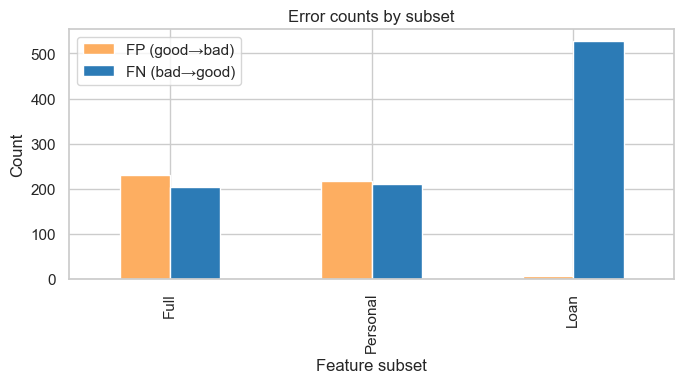

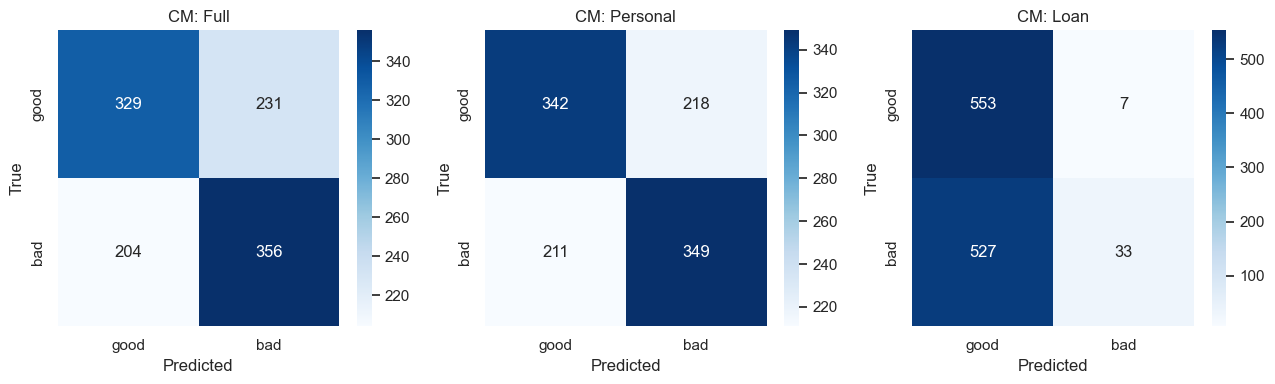

In [27]:
def cm_to_counts(cm):
    # For labels = ['good','bad'], scikit returns:
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    return tn, fp, fn, tp

tn_f, fp_f, fn_f, tp_f = cm_to_counts(m_full["cm"])
tn_p, fp_p, fn_p, tp_p = cm_to_counts(m_personal["cm"])
tn_l, fp_l, fn_l, tp_l = cm_to_counts(m_loan["cm"])

err_df = pd.DataFrame({
    "subset": ["Full","Personal","Loan"],
    "FP (good→bad)": [fp_f, fp_p, fp_l],
    "FN (bad→good)": [fn_f, fn_p, fn_l]
}).set_index("subset")

# 3) Error composition
ax = err_df[["FP (good→bad)","FN (bad→good)"]].plot(
    kind="bar", figsize=(7,4), color=["#fdae61","#2c7bb6"]
)
plt.title("Error counts by subset")
plt.ylabel("Count"); plt.xlabel("Feature subset")
plt.tight_layout()
plt.savefig("outputs/viz_error_counts_by_subset.png", dpi=200)
plt.show()

# 4) Confusion matrices (one figure with 3 panels)
labels = ["good","bad"]
fig, axes = plt.subplots(1,3, figsize=(13,4))
for ax, cm, title in zip(
    axes,
    [m_full["cm"], m_personal["cm"], m_loan["cm"]],
    ["Full","Personal","Loan"]
):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"CM: {title}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.savefig("outputs/viz_confusion_matrices.png", dpi=200)
plt.show()

In [28]:
# Join predictions with key columns and save for each subset
cols = ["ID","Age","Sex","Job","Housing","Saving accounts","Checking account",
        "Credit amount","Duration","Purpose","Risk","y_pred","score"]

(pred_full[cols]).to_csv("outputs/pred_full_with_scores.csv", index=False)
(pred_personal[cols]).to_csv("outputs/pred_personal_with_scores.csv", index=False)
(pred_loan[cols]).to_csv("outputs/pred_loan_with_scores.csv", index=False)

print("Saved:\n - outputs/pred_full_with_scores.csv\n - outputs/pred_personal_with_scores.csv\n - outputs/pred_loan_with_scores.csv")

Saved:
 - outputs/pred_full_with_scores.csv
 - outputs/pred_personal_with_scores.csv
 - outputs/pred_loan_with_scores.csv
